# An√°lise de sentimentos de tweets brasileiros nos per√≠odos anterior e inicial da pandemia de Covid-19
***

<img style="float: left;" src="images/menu_resultados.png" width="800" height="500">

## IV - An√°lise dos resultados

Esta etapa apresentar√° uma **an√°lise dos resultados obtidos** a partir dos **sentimentos de *tweets*** processados pela ferramenta VADER (1), realizados no passo anterior deste trabalho.

A partir de uma **base de dados de casos de Covid-19**, constru√≠da a partir dos **boletins das Secretarias Estaduais de Sa√∫de(SES)** (2), foram calculados intervalos referentes aos **per√≠odos anterior e inicial da pandemia de Covid-19 no Brasil**. Estes intervalos, ent√£o, ficaram divididos em **3 per√≠odos**: **antes do primeiro caso de Covid-19**; **ap√≥s o primeiro caso de Covid-19**; e **ap√≥s a primeira morte por Covid-19**, para cada cidade selecionada.

Em seguida, ap√≥s filtragens realizadas em rela√ß√£o ao intervalo m√≠nimo para cada per√≠odo, ser√£o criados conjuntos contendo cidades com **menores m√©dias *scores* de sentimentos** e **maiores m√©dias de *scores* de sentimentos**. Os limites num√©ricos para a constru√ß√£o destes conjuntos foram extra√≠dos de m√©tricas estat√≠sticas sobre os resultados dos *scores*.

Por fim, ser√£o gerados gr√°ficos com a finalidade de observar **padr√µes comportamentais dos usu√°rios** do Twitter, a partir das **an√°lise de sentimentos** calculadas nos **3 per√≠odos analisados**.

***
### Importa√ß√µes gerais

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re
import numpy as np

from datetime import datetime
from datetime import timedelta

from statistics import mean

import warnings
warnings.filterwarnings('ignore')

### Configura√ß√µes Iniciais

#### Conex√£o ao banco de dados

In [2]:
# Criando estrutura do banco de dados
from pymongo import MongoClient

# Conex√£o com o servidor do MongoDB
client = MongoClient('localhost', 27017)

# Conex√£o com a base de dados do mongoDB
db = client.SpedDB

# Cole√ß√£o onde ser√£o inseridos os dados
collection = db.tweets_brasil

#### Defini√ß√£o de vari√°veis

Nas c√©lulas abaixo s√£o definidas vari√°veis utilizadas no procedimento de an√°lises de resultados.

A vari√°vel referente √†s *hashtags* armazena *strings* a serem desconsideradas nos gr√°ficos de gera√ß√µes de palavras, por serem palavras comuns ao universo dos registros presentes na base de dados (s√£o, em maioria, *hashtags* utilizadas pelo GeoCoV19 para a coleta de *tweets*).

In [3]:
# Hashtags que ser√£o desconsideradas nos items de processamentos de palavras pois s√£o hashtags base que foram utilizados pelo GeoCov19 para sele√ß√£o de todos os tweets (se repetem em todos os tweets)
default_hashtags = ['#coronav√≠rus','#covid19','#covid2019','#covid19brasil','#covid2019brasil','#covid','#corona','#coronavirusbrasil', '#coronavirusnobrasil', '#coronavirus', '#covid-19', '#covid„Éº19', '#covid_19', '#novocoronav√≠rus']

# N√∫mero m√≠nimo de dias por per√≠odo analisado
min_num_days = 3

# Cores
back_color_default = 'slategray'
back_color_dados_neg = 'indianred'
back_color_dados_pos = 'steelblue'

***
### Retornado resultados de tweets selecionados

Nos itens a seguir, √© realizado o **carregamento dos registros com sentimentos processados** pelo VADER. Estes dados s√£o carregados em um *dataframe*.

In [4]:
df = pd.DataFrame.from_records(collection.find({'lang': 'pt', 'score': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'_id': 0}).sort('created_at'))

In [5]:
df.head()

created_at     geo_source      state         city  \
0 2020-02-02 09:32:32  user_location      Piau√≠     Amarante   
1 2020-02-02 09:33:28  user_location  S√£o Paulo     Sorocaba   
2 2020-02-02 09:34:20  user_location      Piau√≠     Amarante   
3 2020-02-02 09:38:24  user_location    Para√≠ba  Jo√£o Pessoa   
4 2020-02-02 09:39:50  user_location  S√£o Paulo      Conchas   

                                                text   score lang  
0  RT @FuturasPromess: RTT ou amanh√£ acordas com ... -0.3400   pt  
1  RT @revistasuper: #SuperLidas A doen√ßa surgiu ...  0.0000   pt  
2  RT @FuturasPromess: RTT ou amanh√£ acordas com ... -0.3400   pt  
3  RT @lelispatricia: Olavo de Carvalho √© o ‚Äúguru... -0.4767   pt  
4  RT @da_goiabeira: Passam a vida criticando a c... -0.3612   pt

***
### Quantitativos de dados a serem analisados

Nos item a seguir s√£o apresentadas totaliza√ß√µes da base de registros que ser√£o analisados e quantitativos por localiza√ß√µes (cidades e estados).

#### Quantidade total de tweets carregados

In [6]:
len(df)

1219385

**Quantidade total de cidades analisadas**

In [7]:
len(df.city.value_counts())

2886

#### Quantidade de *tweets* por estado

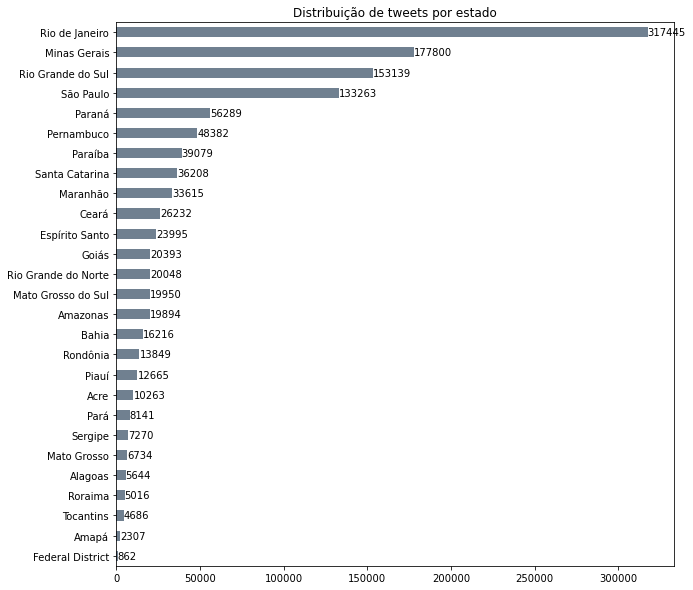

In [8]:
# Distribui√ß√£o de tweets por estado
df.state.value_counts().sort_values().plot(kind='barh', figsize=(10, 10), title='Distribui√ß√£o de tweets por estado', color=back_color_default)

for index, value in enumerate(df.state.value_counts().sort_values()):
    plt.text(value, index, str(value), verticalalignment='center')

#### Quantidade de *tweets* por cidade

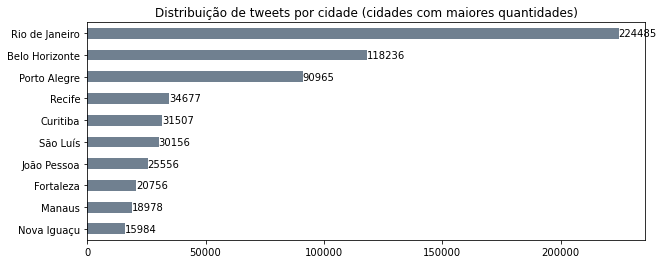

In [9]:
df_city = df.city.value_counts()[:10]

df_city.sort_values().plot(kind='barh', figsize=(10, 4), title='Distribui√ß√£o de tweets por cidade (cidades com maiores quantidades)', color=back_color_default)

for index, value in enumerate(df_city.sort_values()):
    plt.text(value, index, str(value), verticalalignment='center')

***
### Processamento das an√°lises de sentimentos por per√≠odos

Neste ponto, ser√£o iniciados os processamentos que fornecer√£o os **insumos** para a realiza√ß√£o das **an√°lises dos resultados dos sentimentos dos *tweets* nos 3 per√≠odos analisados** (antes do primeiro caso, ap√≥s o primeiro caso e ap√≥s a primeia morte), para cada cidade.

#### Fun√ß√µes auxiliares para processamento de textos

As fun√ß√µes abaixo implementam procedimentos para processamento de textos que fornecer√£o sa√≠das para as gera√ß√µes de gr√°ficos envolvendo a ocorr√™ncia de palavras em um dado conjunto de *tweets*.

A biblioteca ***NLTK*** foi utilizada para a realiza√ß√£o de tarefas como tokeniza√ß√£o e remo√ß√£o de *stopwords*.

In [10]:
import nltk
import collections

from nltk.tokenize import TweetTokenizer
from string import punctuation
from wordcloud import WordCloud, STOPWORDS

from datetime import datetime
from datetime import timedelta

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/mario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Calculando datas de in√≠cio e fim dos per√≠odos

Nos itens a seguir s√£o calculadas as datas de **primeiro caso de Covid-19** e **primeira morte por Covid-19** para cada cidade. Estas datas ser√£o utilizadas para a defini√ß√£o das datas de in√≠cio e fim dos **3 per√≠odos a serem analisados** (antes da primeiro caso, ap√≥s o primeiro caso e ap√≥s a primeira morte) para cada cidade, posteriormente.

Estas datas s√£o **calculadas automaticamente** com a utiliza√ß√£o de uma base de dados constru√≠da a partir dos **boletins das Secretarias Estaduais de Sa√∫de(SES)**. Esta base possui informa√ß√µes de casos confirmados e √≥bitos, por data, para cada munic√≠pio (2).

Durante o c√°lculo de datas de in√≠cio e fim de cada per√≠odo, s√£o **filtradas as cidades que possuem per√≠odos de no m√≠nimo 3 dias**, para minimizar o impacto de per√≠odos muito curtos no c√°lculo da m√©dia de sentimentos por per√≠odos.

O item a seguir **carrega o banco de dados com casos de Covid-19** a partir de um arquivo *CSV*:

In [11]:
# Carregando arquivo CSV contendo casos de Covid-19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

In [12]:
df_cases_brasil.columns

Index(['city', 'date', 'last_available_confirmed',
       'last_available_confirmed_per_100k_inhabitants',
       'last_available_death_rate', 'last_available_deaths', 'state',
       'new_confirmed', 'new_deaths'],
      dtype='object')

No processamento abaixo ocorre o **c√°lculo das datas citadas** inicialmente para cada cidade.

In [13]:
def process_cases_cities_dates(df):
    
    cities = df.groupby(['city','state'])

    cities_cases_date = []
    initial = '2020-02-01'
    final = '2020-05-01'

    for item, state in cities['city','state']:

        city = item[0]
        state = item[1]

        df_cases_city = df_cases_brasil.query('city == "'+city+'"')
        df_cases_city = df_cases_city.reset_index()
        df_cases_city = df_cases_city.drop(columns=['index'])

        if (len(df_cases_city) > 0):

            # Data do primeiro caso 
            first_case = df_cases_city.loc[0, 'date']

            # Data da primeira morte
            result = df_cases_city.query('last_available_deaths != "0"')

            if (len(result) > 0):
                first_death = df_cases_city.loc[min(result.index), 'date']

                initial_date = datetime.strptime(initial, '%Y-%m-%d')
                first_case_date = datetime.strptime(first_case, '%Y-%m-%d')
                first_death_date = datetime.strptime(first_death, '%Y-%m-%d')
                final_date = datetime.strptime(final, '%Y-%m-%d')

                total_days1 = (first_case_date - initial_date).days
                total_days2 = (first_death_date - first_case_date).days
                total_days3 = (final_date - first_death_date).days

                if (total_days1 > min_num_days and total_days2 > min_num_days and total_days3 > min_num_days):
                    data = [city, state, first_case, first_death]
                    cities_cases_date.append(data)

    df_cities_cases_date = pd.DataFrame.from_dict(cities_cases_date)
    df_cities_cases_date.columns = ['city', 'state', 'first_case_date', 'first_death_date']
    
    return df_cities_cases_date

In [14]:
df_cities_cases_date = process_cases_cities_dates(df)

O *dataframe* a seguir exibe um recorte dos registros com as colunas criadas contendo as datas calculadas no processamento realizado acima:

In [15]:
df_cities_cases_date.head()

city           state first_case_date first_death_date
0    Abreu e Lima      Pernambuco      2020-04-09       2020-04-22
1        Acopiara           Cear√°      2020-04-13       2020-04-27
2  Afonso Cl√°udio  Esp√≠rito Santo      2020-04-01       2020-04-24
3          Agudos       S√£o Paulo      2020-04-02       2020-04-08
4         Alian√ßa      Pernambuco      2020-04-01       2020-04-16

Ap√≥s este processamento, o ocorre uma **diminui√ß√£o na quantidade de cidades analisadas**, por conta das filtragens realizadas, como mostrado no c√≥digo abaixo:

In [16]:
len(df_cities_cases_date)

333

In [17]:
df_cities_cases_date.columns

Index(['city', 'state', 'first_case_date', 'first_death_date'], dtype='object')

#### Processamento de dados por per√≠odo

No processamento realizado a seguir ocorre a **gera√ß√£o de dados provenientes das an√°lises de sentimentos e dos conte√∫dos dos *tweets*** das cidades selecionadas at√© ent√£o. Estes dados s√£o processados **para cada cidade e para cada um dos 3 per√≠odos analisados** (antes do primeiro caso, ap√≥s o primeiro caso e ap√≥s a primeira morte).

Os intervalos de datas referentes aos per√≠odos citados s√£o detalhados abaixo:

- **Primeiro Per√≠odo**: Iniciando em 01/02/2020 (data do primeiro registro da base de dados) √† data anterior ao primeiro caso de Covid-19 na cidade;
- **Segundo Per√≠odo**: Iniciando na data do primeiro caso de Covid-19 na cidade √† data anterior √† primeira morte por Covid-19;
- **Terceiro Per√≠odo**: Iniciando na data da primeira morte por Covid-19 na cidade √† 01/05/2020 (data do √∫ltimo registro da base de dados)

Para cada um desses per√≠odos, s√£o gerados os seguintes dados que servir√£o de insumos para as an√°lises realizadas mais adiante neste trabalho:

- **M√©dia de *score* de sentimento total**;
- **M√©dia de *score* de sentimento por per√≠odo**;
- **Quantidade total de *tweets***;
- **Quantidade total de *tweets* por per√≠odo**;
- **100 palavras com maior ocorr√™ncia em frases que mais influenciaram negativamente os *scores* de sentimentos**;
- **100 palavras com maior ocorr√™ncia em frases que mais influenciaram positivamente os *scores* de sentimentos**;

Durante este procedimento, ocorre a filtragem onde s√£o consideradas somentes cidades que possuam no m√≠nimo a quantidade de 300 *tweets* por per√≠odo. Esta sele√ß√£o ajuda a minimizar o impacto no c√°lculo da m√©dia de sentimentos para per√≠odos com poucas quantidade de *tweets*.

In [18]:
# Quantidade m√≠nima de tweets aceit√°veis para cada per√≠odo
min_tweets = 100

# Quantidade m√°xima de tokens a serem retornadas para cada frase analisada
max_tokens = 100

In [19]:
def generate_tweets_tokens(texts):
        
    tokens = []
    
    hashtags_words = ['coronav√≠ru','coronaviru','v√≠ru','viru','corona','coronav√≠rus','coronavirus','virus','v√≠rus','covid','covid19','covid-19', '19']
    words = ['‚Äô','‚Äú','','‚Ä¶','``','...','\'\'','t','https','http','co','rt','pra','pro','vc','pq','q','p','contra','tudo','sobre','a√≠','outro','t√°','vai','ser','estar','est√°','to']
    stopwords = words + default_hashtags + hashtags_words + list(punctuation) + nltk.corpus.stopwords.words('portuguese')
    
    tweet_tokenizer = TweetTokenizer()
    
    for text in texts:        
        words = tweet_tokenizer.tokenize(text)
        for word in words:
            word.encode("ascii", errors="ignore").decode()      
            if word.lower() not in stopwords:
                tokens.append(word.lower())
   
    return tokens

In [20]:
def return_most_negative_tokens(df, end, max_tokens):
    
    top_words = []    
    df_query = df.loc[df['score'] < end]

    words = list(df_query['text'])
    tokens = generate_tweets_tokens(words)
    counter = collections.Counter(tokens)
    
    return dict(counter.most_common(max_tokens))

In [21]:
def return_most_positive_tokens(df, start, max_tokens):
    
    top_words = []    
    df_query = df.loc[df['score'] > start]

    words = list(df_query['text'])
    tokens = generate_tweets_tokens(words)
    counter = collections.Counter(tokens)
    
    return dict(counter.most_common(max_tokens))

In [22]:
def generate_cities_data(df, df_cities_cases_date, min_tweets, max_tokens):

    score_mean = []
    score_mean_1 = []
    score_mean_2 = []
    score_mean_3 = []

    qtd_tweets = []
    qtd_tweets_1 = []
    qtd_tweets_2 = []
    qtd_tweets_3 = []

    tokens_neg = []
    tokens_neg_1 = []
    tokens_neg_2 = []
    tokens_neg_3 = []

    tokens_pos = []
    tokens_pos_1 = []
    tokens_pos_2 = []
    tokens_pos_3 = []

    total_processed = 0

    for index, row in df_cities_cases_date.iterrows():

        city = row['city']
        first_case = row['first_case_date']
        first_death = row['first_death_date']

        total_processed = total_processed + 1

        df_tweets = df.query('city == "'+city+'"')
        df_tweets_1 = df_tweets.query('created_at >= "2020-02-01 00:00:00" and created_at < "'+first_case+' 00:00:00"')  
        df_tweets_2 = df_tweets.query('created_at >= "'+first_case+' 00:00:00" and created_at < "'+first_death+' 00:00:00"')
        df_tweets_3 = df_tweets.query('created_at >= "'+first_death+' 00:00:00" and created_at < "2020-05-02 00:00:00"')

        if (len(df_tweets_1) >= min_tweets and len(df_tweets_2) >= min_tweets and len(df_tweets_3) >= min_tweets):

            score_mean.append(mean(df_tweets['score']))        
            score_mean_1.append(mean(df_tweets_1['score']))
            score_mean_2.append(mean(df_tweets_2['score']))
            score_mean_3.append(mean(df_tweets_3['score']))

            end = df_tweets['score'].describe()['25%']

            tokens_city_neg = return_most_negative_tokens(df_tweets, end, max_tokens)
            tokens_city_neg_1 = return_most_negative_tokens(df_tweets_1, end, max_tokens)
            tokens_city_neg_2 = return_most_negative_tokens(df_tweets_2, end, max_tokens)
            tokens_city_neg_3 = return_most_negative_tokens(df_tweets_3, end, max_tokens)

            tokens_neg.append(tokens_city_neg)
            tokens_neg_1.append(tokens_city_neg_1)
            tokens_neg_2.append(tokens_city_neg_2)
            tokens_neg_3.append(tokens_city_neg_3)

            start = df_tweets['score'].describe()['75%']

            tokens_city_pos = return_most_positive_tokens(df_tweets, start, max_tokens)
            tokens_city_pos_1 = return_most_positive_tokens(df_tweets_1, start, max_tokens)
            tokens_city_pos_2 = return_most_positive_tokens(df_tweets_2, start, max_tokens)
            tokens_city_pos_3 = return_most_positive_tokens(df_tweets_3, start, max_tokens)

            tokens_pos.append(tokens_city_pos)
            tokens_pos_1.append(tokens_city_pos_1)
            tokens_pos_2.append(tokens_city_pos_2)
            tokens_pos_3.append(tokens_city_pos_3)

            qtd_tweets.append(len(df_tweets))
            qtd_tweets_1.append(len(df_tweets_1))
            qtd_tweets_2.append(len(df_tweets_2))
            qtd_tweets_3.append(len(df_tweets_3))

        else:
            df_cities_cases_date = df_cities_cases_date.drop(index)

        print(total_processed,'processado(s)')

    df_cities_cases_date['score_mean'] = score_mean
    df_cities_cases_date['score_mean_1'] = score_mean_1
    df_cities_cases_date['score_mean_2'] = score_mean_2
    df_cities_cases_date['score_mean_3'] = score_mean_3

    df_cities_cases_date['tokens_neg'] = tokens_neg
    df_cities_cases_date['tokens_neg_1'] = tokens_neg_1
    df_cities_cases_date['tokens_neg_2'] = tokens_neg_2
    df_cities_cases_date['tokens_neg_3'] = tokens_neg_3

    df_cities_cases_date['tokens_pos'] = tokens_pos
    df_cities_cases_date['tokens_pos_1'] = tokens_pos_1
    df_cities_cases_date['tokens_pos_2'] = tokens_pos_2
    df_cities_cases_date['tokens_pos_3'] = tokens_pos_3

    df_cities_cases_date['qtd_tweets'] = qtd_tweets
    df_cities_cases_date['qtd_tweets_1'] = qtd_tweets_1
    df_cities_cases_date['qtd_tweets_2'] = qtd_tweets_2
    df_cities_cases_date['qtd_tweets_3'] = qtd_tweets_3
    
    return df_cities_cases_date

In [23]:
df_cities_cases_date = generate_cities_data(df, df_cities_cases_date, min_tweets, max_tokens)

1 processado(s)
2 processado(s)
3 processado(s)
4 processado(s)
5 processado(s)
6 processado(s)
7 processado(s)
8 processado(s)
9 processado(s)
10 processado(s)
11 processado(s)
12 processado(s)
13 processado(s)
14 processado(s)
15 processado(s)
16 processado(s)
17 processado(s)
18 processado(s)
19 processado(s)
20 processado(s)
21 processado(s)
22 processado(s)
23 processado(s)
24 processado(s)
25 processado(s)
26 processado(s)
27 processado(s)
28 processado(s)
29 processado(s)
30 processado(s)
31 processado(s)
32 processado(s)
33 processado(s)
34 processado(s)
35 processado(s)
36 processado(s)
37 processado(s)
38 processado(s)
39 processado(s)
40 processado(s)
41 processado(s)
42 processado(s)
43 processado(s)
44 processado(s)
45 processado(s)
46 processado(s)
47 processado(s)
48 processado(s)
49 processado(s)
50 processado(s)
51 processado(s)
52 processado(s)
53 processado(s)
54 processado(s)
55 processado(s)
56 processado(s)
57 processado(s)
58 processado(s)
59 processado(s)
60 pro

Recorte do *dataframe* contendo os dados gerados para cada cidade e cada per√≠odo realizados acima:

In [24]:
df_cities_cases_date.head()

city              state first_case_date first_death_date  \
5     Alvorada  Rio Grande do Sul      2020-03-19       2020-04-08   
8   Ananindeua               Par√°      2020-03-25       2020-04-17   
12     Aracaju            Sergipe      2020-03-14       2020-04-02   
19    Araruama     Rio de Janeiro      2020-04-03       2020-04-15   
23   Ara√ßatuba          S√£o Paulo      2020-03-31       2020-04-22   

    score_mean  score_mean_1  score_mean_2  score_mean_3  \
5    -0.067740     -0.034808     -0.047727     -0.097979   
8    -0.064621     -0.015744     -0.082463     -0.069172   
12   -0.050649     -0.027901     -0.052965     -0.054076   
19   -0.034999     -0.028331     -0.071603     -0.025439   
23   -0.050296     -0.052457     -0.066246     -0.015035   

                                           tokens_neg  \
5   {'brasil': 10, 'pessoas': 10, 'morrer': 9, 'üò≠'...   
8   {'pessoas': 87, 'casos': 67, 'par√°': 53, 'todo...   
12  {'brasil': 151, 'bolsonaro': 99, 'casos': 85, ...   
19  {'live': 20, 'porra': 14, 'casa': 14, 'gente':...   
23  {'#portallr1': 31, 'mat√©ria': 25, 'leia': 24, ...   

                                         tokens_neg_1  \
5   {'mundo': 5, 'ta': 4, 'todo': 4, 'olha': 3, 'm...   
8   {'Ô∏è': 8, '‚ï±': 6, '‚ï≤': 6, '‚ö†': 6, '‚ñî': 5, 'casa...   
12  {'brasil': 13, 'china': 10, 'medo': 9, 'gripe'...   
19  {'live': 18, 'porra': 7, 'morrer': 7, 'foda': ...   
23  {'#portallr1': 18, 'mat√©ria': 12, 'leia': 11, ...   

                                         tokens_neg_2  \
5   {'casa': 6, 'agora': 5, 'matar': 5, 'caso': 4,...   
8   {'casos': 25, 'par√°': 25, 'pessoas': 24, 'conf...   
12  {'bolsonaro': 27, 'crise': 21, 'brasil': 16, '...   
19  {'guerra': 7, 'casa': 7, 'china': 5, 'agora': ...   
23  {'morte': 13, 'ara√ßatuba': 10, 'leia': 10, 'ma...   

                                         tokens_neg_3  \
5   {'@correio_dopovo': 7, 'primeira': 7, 'sa√∫de':...   
8   {'pessoas': 60, 'casos': 42, 'todo': 30, 'conf...   
12  {'brasil': 122, 'casos': 72, 'bolsonaro': 71, ...   
19  {'dia': 7, 'gente': 6, 'cara': 5, 'porra': 4, ...   
23  {'‚ö∞': 6, 'mortos': 5, 'mil': 5, 'ter': 5, '‚Äù':...   

                                           tokens_pos  \
5   {'agora': 14, 'casa': 11, 'fazer': 10, 'bolson...   
8   {'Ô∏è': 30, 'ontem': 29, 'pessoas': 27, 'anos': ...   
12  {'casos': 146, 'brasil': 130, 'Ô∏è': 82, '‚ñ∂': 77...   
19  {'üòÇ': 21, 'vou': 13, 'amigos': 13, 'casa': 11,...   
23  {'#portallr1': 32, 'leia': 28, 'mat√©ria': 28, ...   

                                         tokens_pos_1  \
5   {'t√£o': 6, 'amigos': 5, 'ningu√©m': 4, 'ü§£': 4, ...   
8   {'‚úä': 11, 'üèæ': 11, 'ainda': 5, 'n√©': 5, 'prime...   
12  {'brasil': 13, 'c': 12, 'sa√∫de': 11, 'aqui': 1...   
19  {'vou': 10, 'acho': 10, 'ainda': 9, 'casa': 8,...   
23  {'#portallr1': 12, 'leia': 8, 'mat√©ria': 8, 'c...   

                                         tokens_pos_2  \
5   {'agora': 8, 'casa': 8, 'ai': 5, 'üòë': 4, 'mund...   
8   {'positivo': 11, 'sa√∫de': 10, 'Ô∏è': 10, 'deus':...   
12  {'brasil': 23, 'deus': 21, 'bolsonaro': 15, 't...   
19  {'üòÇ': 10, '‚Ä¢': 5, 'aula': 4, 'obrigada': 3, 'a...   
23  {'brasil': 9, 'pandemia': 8, 'leia': 8, 'mat√©r...   

                                         tokens_pos_3  qtd_tweets  \
5   {'pode': 8, 'bolsonaro': 6, 'ano': 6, 'm√°scara...         812   
8   {'ontem': 27, 'anos': 20, 'Ô∏è': 19, 'pessoas': ...        1429   
12  {'casos': 129, 'brasil': 94, 'Ô∏è': 77, '‚ñ∂': 75,...        5710   
19  {'üòÇ': 7, 'ü§£': 6, 'deus': 5, 'assim': 4, 'quare...         862   
23  {'18': 13, '99141-8872': 13, '#quarentena': 12...        1186   

    qtd_tweets_1  qtd_tweets_2  qtd_tweets_3  
5            193           246           373  
8            267           584           578  
12           695          1237          3778  
19           471           149           242  
23           514           441           231

Ap√≥s as filtragens realizadas no procedimento anterior, em rela√ß√£o ao n√∫meros de dias m√≠nimos de per√≠odos, o n√∫mero de cidades consideradas para an√°lise **diminuiu** para a quantidade abaixo:

In [25]:
len(df_cities_cases_date)

106

A imagem a seguir ilustra os passos realizados neste *notebook* para gera√ß√£o dos insumos a serem utilizados na an√°lise dos resultados.

<img style="float: left;" src="images/fluxo_resultados.png">

***
### Resultados obtidos

Esta se√ß√£o apresenta, por meio de gr√°ficos e quantitativos, os resultados obtidos neste trabalho. 

Para a an√°lise desses resultados, as cidades selecionadas at√© ent√£o foram divididas em dois conjuntos: cidades com **menores m√©dias de *scores* de sentimentos** e cidades com **maiores m√©dias de *scores* de sentimentos**. Os limites num√©ricos utilizados na constru√ß√£o desses conjuntos foram obtidos a partir de **m√©tricas estat√≠sticas realizadas sobre os resultados dos *scores* obtidos**.

Esta divis√£o tem por finalidade observar **padr√µes comportamentais** expressos pelos usu√°rios do Twitter, por meio dos resultados das an√°lises de sentimentos calculadas nos **3 per√≠odos analisados** por este trabalho (antes do primeiro caso, ap√≥s o primeiro caso e ap√≥s a primeira morte).

**Constru√ß√£o dos conjuntos de cidades com menores e maiores m√©dias de *scores* de sentimentos**

No item a seguir, s√£o calculadas m√©tricas estat√≠sticas com base na m√©dia de *scores*:

In [26]:
df_cities_cases_date['score_mean'].describe()

count    106.000000
mean      -0.043718
std        0.019824
min       -0.098871
25%       -0.055014
50%       -0.044276
75%       -0.031903
max        0.006627
Name: score_mean, dtype: float64

Com base nas m√©tricas obtidas s√£o constru√≠dosa seguir os dois conjuntos desejados:
- Conjunto contendo cidades com as **menores m√©dias de *scores*** (considerando dados pertencentes ao **primeiro quartil**);
- Conjunto contendo cidades com as **maiores m√©dias de *scores*** (considerando dados pertencentes ao **√∫ltimo quartil**).

In [27]:
end_cities_neg = df_cities_cases_date['score_mean'].describe()['25%']

df_cities_neg = df_cities_cases_date.loc[df_cities_cases_date['score_mean'] < end_cities_neg]
df_cities_neg = df_cities_neg.reset_index(drop=True)

In [28]:
start_cities_pos = df_cities_cases_date['score_mean'].describe()['75%']

df_cities_pos = df_cities_cases_date.loc[df_cities_cases_date['score_mean'] > start_cities_pos]
df_cities_pos = df_cities_pos.reset_index(drop=True)

As c√©lulas abaixo totalizam, respectivamente, as quantidades de cidades contidas no primeiro e no segundo conjunto constru√≠dos acima:

In [29]:
len(df_cities_neg)

27

In [30]:
len(df_cities_pos)

27

**Gr√°ficos de totaliza√ß√µes dos conjuntos de cidades**

Conunto contendo cidades com as **menores m√©dias de *scores*** de sentimentos

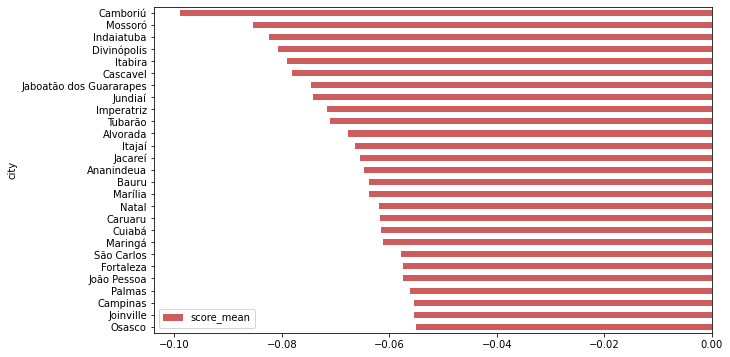

In [31]:
df_cities_neg.sort_values(by=['score_mean'], ascending=False).plot(kind='barh', x='city', y='score_mean', figsize=(10, 6), color=back_color_dados_neg)

Conjunto contendo cidades com as **maiores m√©dias de *scores* de sentimentos**

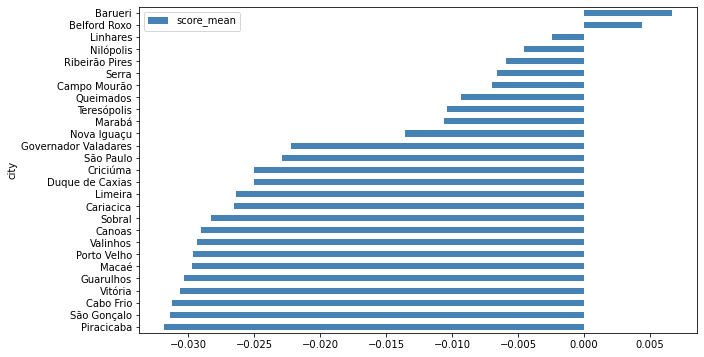

In [32]:
df_cities_pos.sort_values(by=['score_mean'], ascending=True).plot(kind='barh', x='city', y='score_mean', figsize=(10, 6), color=back_color_dados_pos)

***
**M√©tricas dos conjuntos de cidades**

M√©tricas das cidades com **menores m√©dias de *scores* de sentimentos**

In [33]:
df_cities_neg['score_mean'].describe()

count    27.000000
mean     -0.067724
std       0.010958
min      -0.098871
25%      -0.074354
50%      -0.064621
75%      -0.059479
max      -0.055026
Name: score_mean, dtype: float64

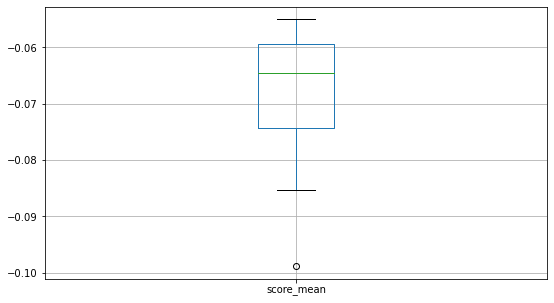

In [34]:
boxplot = df_cities_neg.boxplot(column=['score_mean'], grid=True, figsize=(9, 5))

M√©tricas das cidades com **maiores m√©dias de *scores* de sentimentos**

In [35]:
df_cities_pos['score_mean'].describe()

count    27.000000
mean     -0.018833
std       0.012216
min      -0.031785
25%      -0.029497
50%      -0.024967
75%      -0.008173
max       0.006627
Name: score_mean, dtype: float64

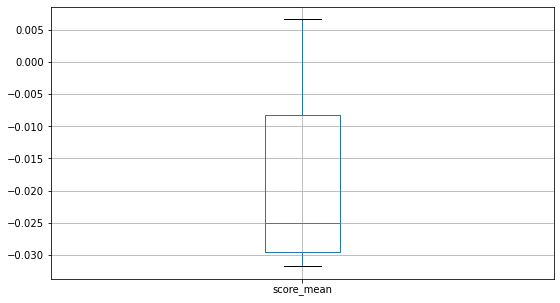

In [36]:
boxplot = df_cities_pos.boxplot(column=['score_mean'], grid=True, figsize=(9, 5))

De acordo com as m√©tricas obtidas acima:
- Os *scores* das 10 cidades com **menores m√©dias** de sentimentos **variam de -0.061920 a -0.054979**, com **m√©dia de -0.057929**.
- Os *scores* das 10 cidades com **maiores m√©dias** de sentimentos **variam de -0.031394 a 0.004392**, com **m√©dia de -0.023543**.

Observa-se que os dois conjuntos analisados possuem **m√©dias de *scores* de sentimentos negativos e bem pr√≥ximos a zero**. O que pode ser um indicativo de **neutralidade** em rela√ß√£o aos sentimentos de *tweets* dos conjuntos analisados. 

***
**M√©dias de sentimentos por per√≠odo**

Os gr√°ficos abaixo consolidam dados referentes √†s m√©dias de *scores* de sentimentos para as cidades com menores e maiores m√©dias de *scores* de sentimentos, em cada per√≠odo analisado.

*Fun√ß√µes auxiliares*

In [37]:
def generate_cities_means_bars(df, title):
    
    bar_width = 0.25

    means_1 = list(df['score_mean_1'])
    means_2 = list(df['score_mean_2'])
    means_3 = list(df['score_mean_3'])

    # Cria eixo x para produto A e produto B com uma separa√ß√£o de 0.25 entre as barras
    x1 =  np.arange(len(means_1))
    x2 = [x + bar_width for x in x1]
    x3 = [x + bar_width for x in x2]

    # Plota as barras
    plt.bar(x1, means_1, width=bar_width, label = 'Antes do 1¬∫ caso', color = 'moccasin')
    plt.bar(x2, means_2, width=bar_width, label = 'Ap√≥s o 1¬∫ caso', color = 'sandybrown')
    plt.bar(x3, means_3, width=bar_width, label = 'Ap√≥s a 1¬™ morte', color = 'indianred')

    # coloca o nome dos meses como label do eixo x
    cities = list(df['city'])
    plt.xticks([x + bar_width for x in range(len(means_1))], cities)

    # inseri uma legenda no gr√°fico
    plt.legend()

    plt.title(title)
    plt.xticks(x1, rotation=90)
    plt.xticks(x2, rotation=90)
    plt.xticks(x3, rotation=90)
    plt.show()

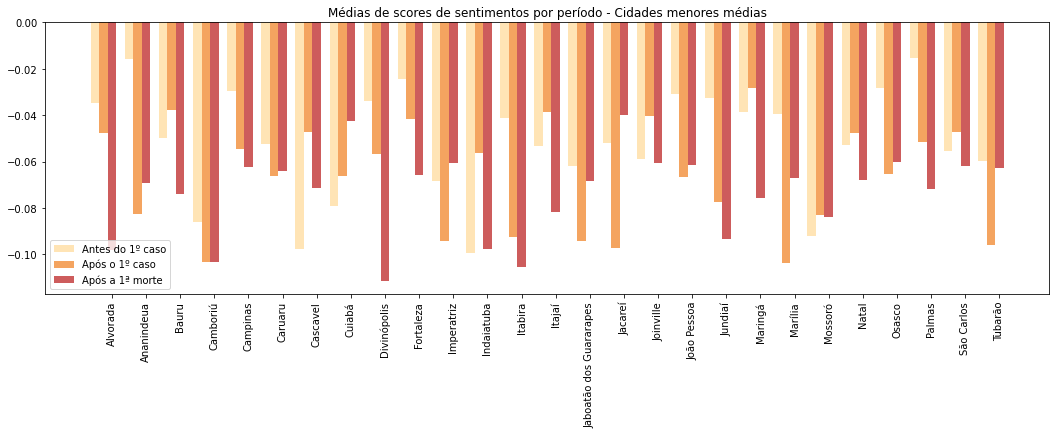

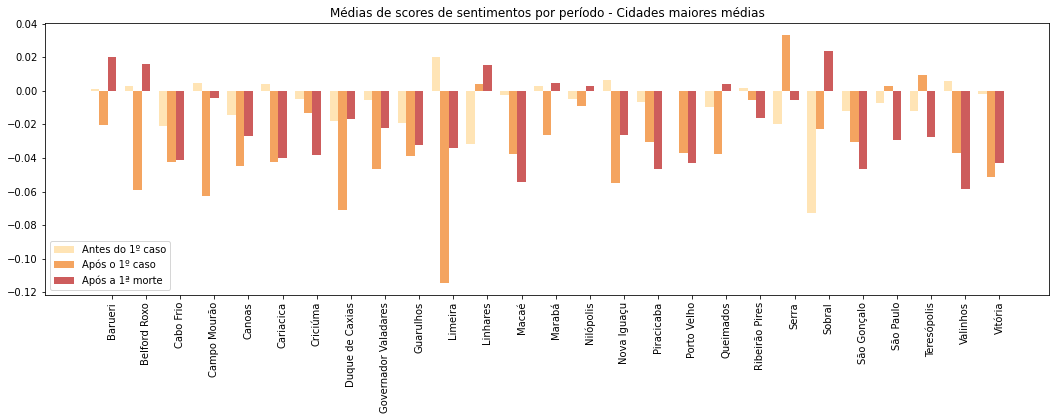

In [64]:
generate_cities_means_bars(df_cities_neg, 'M√©dias de scores de sentimentos por per√≠odo - Cidades menores m√©dias')
generate_cities_means_bars(df_cities_pos, 'M√©dias de scores de sentimentos por per√≠odo - Cidades maiores m√©dias')

Com base nos gr√°ficos acima, podem ser extra√≠das as seguintes observa√ß√µes:

- Nas cidades com **menores m√©dias**, os **resultado obtidos nos 3 per√≠odos** analisados s√£o **negativos** em todos os casos;
- Nas cidades com **maiores m√©dias**, algumas delas, apresentam **m√©dias positivas em alguns per√≠odos** e os resultados do **primeiro per√≠odo** s√£o **melhores** comparados √†s cidades com menores menores m√©dias.


- Na maioria das cidades com **menores m√©dias** (17 das 27 cidades), os resultados **pioraram entre o segundo e o terceiro per√≠odo**;
- Tamb√©m na maioria das cidades com **maiores m√©dias** (22 das 27 cidades), os resultados pioraram na mesma compara√ß√£o.


- Na maioria das cidades com **menores m√©dias** (17 das 27 cidades), os resultados **pioraram entre o segundo e terceiro per√≠odo**;
- J√° na maioria das cidades com **maiores m√©dias** (16 das 27 cidades) estes resultados **melhoraram**.

A partir dessas observa√ß√µes pode-se questionar: 

- O fato de que as cidades com **maiores m√©dias** apresentaram **resultados melhores no primeiro per√≠odo** (antes do primeiro caso) pode ser um indicativo de **percep√ß√£o tardia da popula√ß√£o aos efeitos da pandemia**?


- O fato de que **entre o primeiro e o segundo per√≠odo** houve uma **piora nos dois conjuntos** analisados significa que **ocorreu um alinhamento do comportamento de usu√°rios em rela√ß√£o aos efeitos da pandemia**?


- Considerando que **entre o segundo e o terceiro per√≠odo**, as cidades com **maiores m√©dias** apresentaram melhora, pode significar uma **melhor rea√ß√£o dos usu√°rios em rela√ß√£o aos efeitos da pandemia do que os usu√°rios das cidades com menores m√©dias**?

***
**An√°lise da influ√™ncias negativas e positivas de palavras nos sentimentos dos *tweets***

Para auxiliar na contextualiza√ß√£o dos resultados obtidos no passo anterior, esta se√ß√£o far√° uma an√°lise em rela√ß√£o √† ocorr√™ncia de palavras nas frases que mais influenciaram negativamente ou positivamente nos resultados das m√©dias de *scores* de sentimentos obtidos.

*Fun√ß√µes utilizadas para gera√ß√µes de gr√°ficos*

In [39]:
max_bars_words = 5
max_clouds_words = 100

back_color_cidades_neg = 'mistyrose'
back_color_cidades_pos = 'aliceblue'

In [40]:
from collections import Counter

In [41]:
def return_tokens_freq(dicts, max_res):
    
    final = Counter({})    
    for tokens_dict in dicts: 
        final = Counter(final) + Counter(tokens_dict)
                
    return dict(final.most_common(max_res))

In [42]:
def generate_bar_from_tokens_freq(dicts, max_res, color, x, y, title):
    
    tokens_freq = return_tokens_freq(dicts, max_res)
    df_words = pd.DataFrame().from_dict(tokens_freq, orient='index', columns=['total'])
    df_words = df_words.sort_values(by = ['total'], ascending=[False])
    df_words = df_words[:max_res]
    df_words.sort_values(by = ['total'], ascending=[True]).plot(kind='barh', figsize=(x, y), color=color, title=title)

In [43]:
def generate_clouds_from_tokens_freq(dicts1, dicts2, max_res, words_color, back_color1, back_color2):
    
    tokens_freq1 = return_tokens_freq(dicts1, max_res)
    wordcloud1 = WordCloud(background_color=back_color1, max_words=100, normalize_plurals=False, color_func=lambda *args, **kwargs: words_color).generate_from_frequencies(tokens_freq1)

    tokens_freq2 = return_tokens_freq(dicts2, max_res)
    wordcloud2 = WordCloud(background_color=back_color2, max_words=100, normalize_plurals=False, color_func=lambda *args, **kwargs: words_color).generate_from_frequencies(tokens_freq2)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    
    ax1.set_facecolor(back_color1)
    ax2.set_facecolor(back_color2)
    
    ax1.imshow(wordcloud1, interpolation='bilinear')    
    ax1.axis("off")
    
    ax2.imshow(wordcloud2, interpolation='bilinear')    
    ax2.axis("off")

In [44]:
def create_df_from_freq(dicts, max_res):
    tokens_freq = return_tokens_freq(dicts, max_res)
    df_words = pd.DataFrame().from_dict(tokens_freq, orient='index', columns=['total'])
    df_words = df_words.sort_values(by = ['total'], ascending=[False])
    df_words = df_words[:max_res]
    df_words = df_words.sort_values(by = ['total'], ascending=[True])  
    return df_words

In [45]:
def generate_cities_bars(dicts1, dicts2, max_res, bar_color, back_color1, back_color2):

    df1 = create_df_from_freq(dicts1, max_res)
    df2 = create_df_from_freq(dicts2, max_res)

    fig, (ax1, ax2) = plt.subplots(ncols=2)
    
    ax1.set_facecolor(back_color1)
    ax2.set_facecolor(back_color2)

    df1.plot(kind='barh', ax=ax1, color=bar_color, title='Cidades com menores m√©dias')
    df2.plot(kind='barh', ax=ax2, color=bar_color, title='Cidades com maiores m√©dias')

    plt.show()

In [46]:
def generate_periods_cities_bars(dicts1, dicts2, dicts3, dicts4, dicts5, dicts6, max_res, bar_color, back_color1, back_color2):

    df1 = create_df_from_freq(dicts1, max_res)
    df2 = create_df_from_freq(dicts2, max_res)
    df3 = create_df_from_freq(dicts3, max_res) 
    
    df4 = create_df_from_freq(dicts4, max_res)
    df5 = create_df_from_freq(dicts5, max_res)
    df6 = create_df_from_freq(dicts6, max_res)

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
    fig, (ax4, ax5, ax6) = plt.subplots(ncols=3)
    
    ax1.set_facecolor(back_color1)
    ax2.set_facecolor(back_color1)
    ax3.set_facecolor(back_color1)
    
    ax4.set_facecolor(back_color2)
    ax5.set_facecolor(back_color2)
    ax6.set_facecolor(back_color2)

    df1.plot(kind='barh', ax=ax1, color=bar_color, title='Antes do 1¬∫ caso')
    df2.plot(kind='barh', ax=ax2, color=bar_color, title='Depois do 1¬∫ caso')
    df3.plot(kind='barh', ax=ax3, color=bar_color, title='Ap√≥s 1¬™ morte')
    
    df4.plot(kind='barh', ax=ax4, color=bar_color, title='Antes do 1¬∫ caso')
    df5.plot(kind='barh', ax=ax5, color=bar_color, title='Depois do 1¬∫ caso')
    df6.plot(kind='barh', ax=ax6, color=bar_color, title='Ap√≥s 1¬™ morte')

    plt.show()

Palavras presentes nas frases que **mais influenciaram negativamente**

Os passos abaixo exibem gr√°ficos que ajudam a visualiza√ß√£o das palavras presentes nas frases que mais influenciaram **negativamente** (destacadas pela cor avermelhada) nos conjuntos de cidades analisados.

As nuvens de palavras abaixo exibem o conjunto de palavras em quest√£o para as cidades com **menores m√©dias** (*backgroud* avermelhado) e cidades com **maiores m√©dias** (*background* azulado). O item seguinte exibe gr√°ficos com as 5 palavras de maior ocorr√™ncia nestas nuvens.

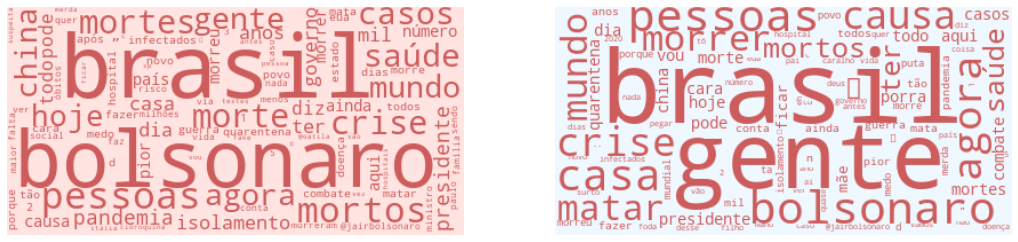

In [63]:
generate_clouds_from_tokens_freq(df_cities_neg['tokens_neg'], df_cities_pos['tokens_neg'], max_clouds_words, back_color_dados_neg, back_color_cidades_neg, back_color_cidades_pos)

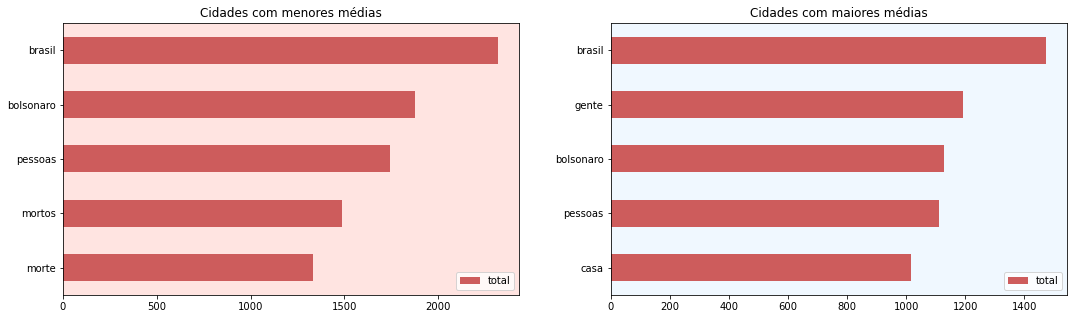

In [62]:
generate_cities_bars(df_cities_neg['tokens_neg'], df_cities_pos['tokens_neg'], max_bars_words, back_color_dados_neg, back_color_cidades_neg, back_color_cidades_pos)

Os gr√°ficos abaixo exibem as 5 palavras de maior ocorr√™ncia no conjunto de palavras em quest√£o, nos 3 per√≠odos analisados, para as cidades com menores m√©dias (*background* avermelhado) e maiores m√©dias de sentimentos (*background* azulado).

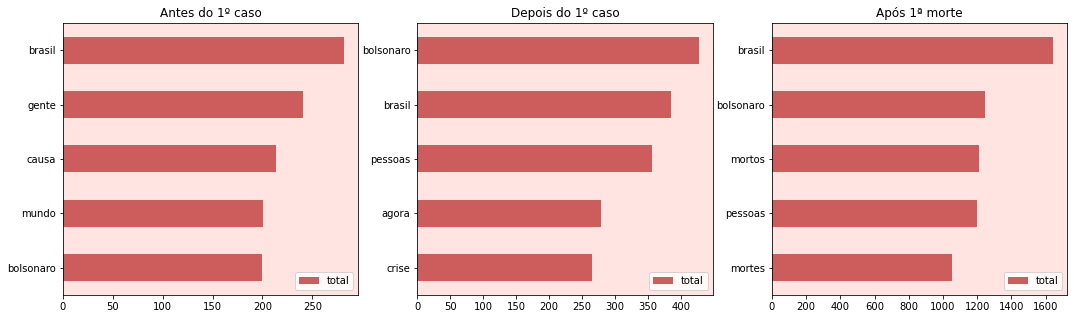

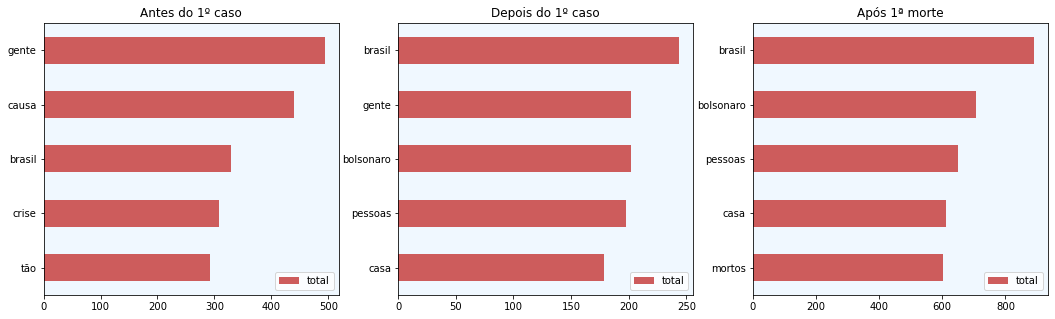

In [61]:
generate_periods_cities_bars(df_cities_neg['tokens_neg_1'], df_cities_neg['tokens_neg_2'], df_cities_neg['tokens_neg_3'], df_cities_pos['tokens_neg_1'], df_cities_pos['tokens_neg_2'], df_cities_pos['tokens_neg_3'], max_bars_words, back_color_dados_neg, back_color_cidades_neg, back_color_cidades_pos)

Palavras presentes nas frases que **mais influenciaram positivamente**

Os passos abaixo exibem gr√°ficos que ajudam a visualiza√ß√£o das palavras presentes nas frases que mais influenciaram **positivamente** (destacadas pela cor azulada) nos conjuntos de cidades analisados. O item seguinte exibe gr√°ficos com as 5 palavras de maior ocorr√™ncia nestas nuvens.

As nuvens de palavras abaixo exibem o conjunto de palavras em quest√£o para as cidades com **menores m√©dias** (*backgroud* avermelhado) e cidades com **maiores m√©dias** (*background* azulado).

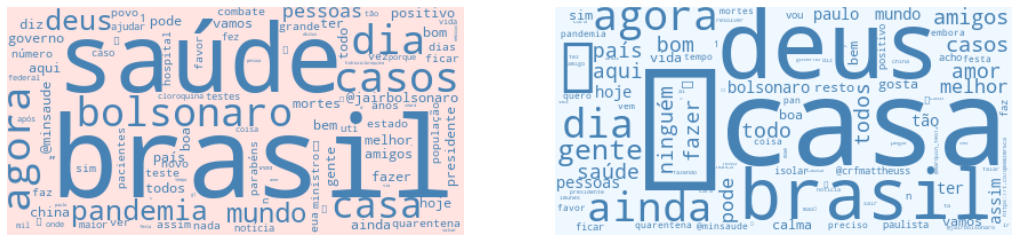

In [60]:
generate_clouds_from_tokens_freq(df_cities_neg['tokens_pos'], df_cities_pos['tokens_pos'], max_clouds_words, back_color_dados_pos, back_color_cidades_neg, back_color_cidades_pos)

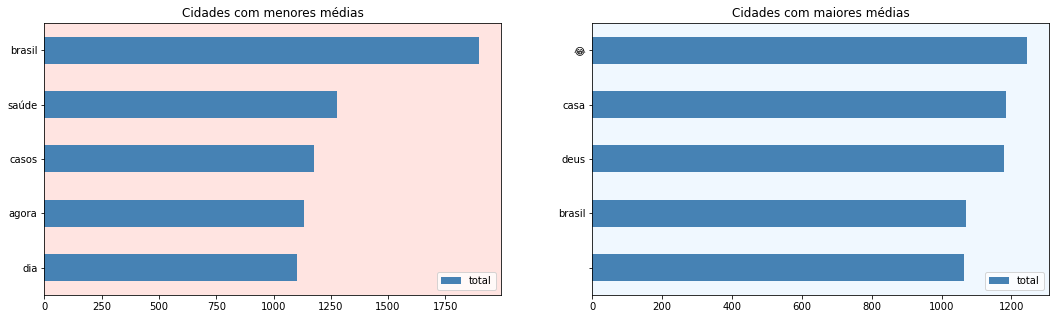

In [59]:
generate_cities_bars(df_cities_neg['tokens_pos'], df_cities_pos['tokens_pos'], max_bars_words, back_color_dados_pos, back_color_cidades_neg, back_color_cidades_pos)

Os gr√°ficos abaixo exibem as 5 palavras de maior ocorr√™ncia no conjunto de palavras em quest√£o, nos 3 per√≠odos analisados, para as cidades com menores m√©dias (*background* avermelhado) e maiores m√©dias de sentimentos (*background* azulado).

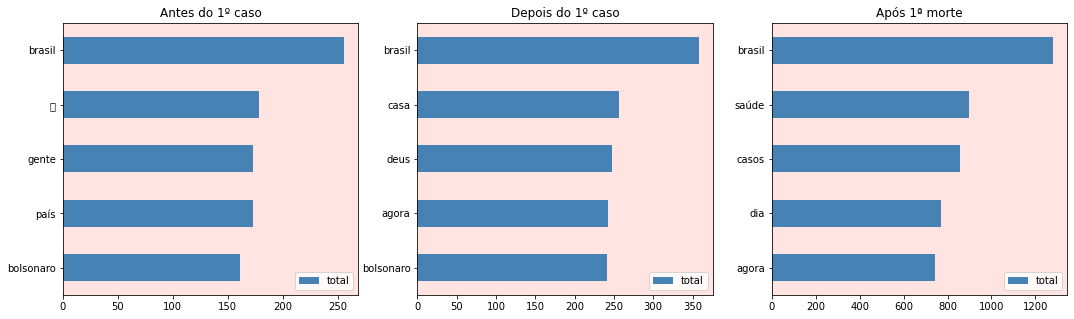

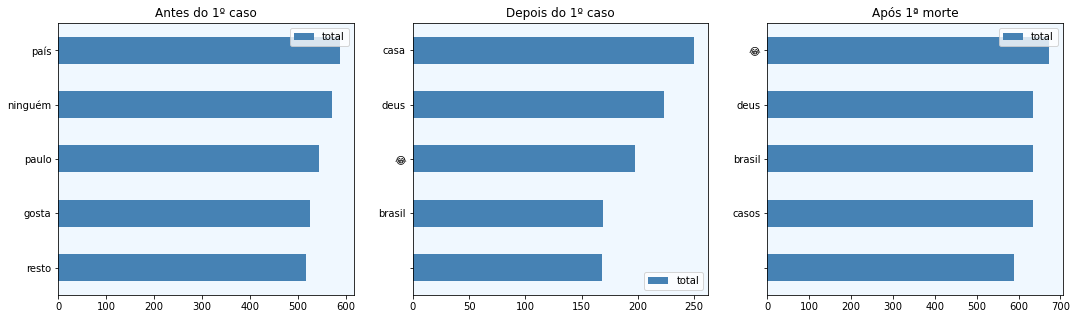

In [58]:
generate_periods_cities_bars(df_cities_neg['tokens_pos_1'], df_cities_neg['tokens_pos_2'], df_cities_neg['tokens_pos_3'], df_cities_pos['tokens_pos_1'], df_cities_pos['tokens_pos_2'], df_cities_pos['tokens_pos_3'], max_bars_words, back_color_dados_pos, back_color_cidades_neg, back_color_cidades_pos)

Com base nos gr√°ficos acima pode-se extrair as seguintes observa√ß√µes:

- A palavra **"bolsonaro"** est√° presente nos gr√°ficos de influ√™ncia negativa em ambos os conjuntos de cidades analisados;


- Nas cidades com **maiores m√©dias** a men√ß√£o ao presidente da rep√∫blica ocorre em menor n√∫mero e em menor ocorr√™ncia, nos recortes analisados;


- Tendo em vista que, no gr√°fico da se√ß√£o anterior, os resultados para o **primeiro per√≠odo** das cidades com **maiores m√©dias** apresenta resultados superiores, observa-se que, neste recorte, a palavra **"bolsonaro" n√£o est√° presente**;


- No terceiro per√≠odo (ap√≥s √† primeira morte), nos dois conjuntos de cidades analisados, percebe-se a ocorr√™ncia de palavras como **"morte"** e **"mortos"**.

A partir dessas observa√ß√µes pode-se questionar: 

- A grande ocorr√™ncia de men√ß√µes ao presidente da rep√∫blica presentes nas an√°lises acima podem ser um ind√≠cio de **engajamento pol√≠tico** entre usu√°rios da rede social analisada?


- A ocorr√™ncia de **"bolsonaro"** entre os gr√°ficos de influ√™ncia negativa pode sugerir uma desaprova√ß√£o ao governo federal? 


- Considerando que **"bolsonaro"** ocorre em **maior quantidade** nos gr√°ficos das cidades com **menores m√©dias** e em **menor quantidade e menor ocorr√™ncia** nas cidades com **maiores m√©dias** pode-se sugerir uma **polariza√ß√£o pol√≠tica** nas discuss√µes entre os usu√°rios do Twitter? 


- A mesma afirma√ß√£o acima pode sugerir que as cidades com maiores m√©dias **n√£o estavam t√£o engajadas politicamente** em rela√ß√£o √†s de menores m√©dias?


- Considerando que as **palavras que faziam refer√™ncia √† morte** surgiram nos gr√°ficos de palavras negativas do terceiro per√≠odo pode-se sugerir que os usu√°rios do Twitter externalizaram um comportamento sens√≠vel ao fato de ocorr√™ncia da primeira morte por Covid-19 em suas cidades.

***
**M√©dia de *scores* de sentimento por dia das cidades com menores e maiores m√©dias**

Os gr√°ficos a seguir exibem as **m√©dias di√°rias de *scores* de sentimentos**, para as **cidades com menores e maiores m√©dias**. As linhas verticais vermelhas e preta simbolizam, respectivamente, a data do primeiro caso e a data da primeira morte por Covid-19, em cada cidade.

*Fun√ß√µes utilizadas na gera√ß√£o dos gr√°ficos*

In [53]:
# Fun√ß√£o para montar um df de Quantificadores por data a partir do df de Tweets
def building_dates_df(df, date_list, column):

    score_mean_list = []
        
    # Populando quantificadores para cada dia
    for index in date_list:
        
        try:
            # M√©dia de scores do per√≠odo
            score_mean = mean(df[column].loc[(df['created_at'].dt.year == index.year) & (df['created_at'].dt.month == index.month) & (df['created_at'].dt.day == index.day)])
            score_mean_list.append(score_mean)
        except:
            score_mean_list.append(0)
    
    # Dicion√°rio utilizado como par√¢metro para a montagem
    data={'created_at': pd.Series(date_list), column + '_mean':pd.Series(score_mean_list)}
    
    # Criando df
    df = pd.DataFrame(data)
    
    return df 

In [54]:
def generate_cities_means_lines(df, df_cities, title):
    
    df_cities = df_cities.reset_index()
    
    cities = list(df_cities['city'])   
    fig, ax = plt.subplots()
    
    date_list = list(pd.to_datetime(df['created_at']).dt.date.unique())
      
    for index, row in df_cities.iterrows():
        
        df_scores = df.loc[df['city'] == row['city']]
        df_dates = building_dates_df(df_scores, date_list, 'score')   
        
        x = date_list
        y = df_dates.score_mean
        
        first_case_date_str = row['first_case_date']
        first_case_date = datetime.strptime(first_case_date_str, '%Y-%m-%d')
        
        first_death_date_str = row['first_death_date']
        first_death_date = datetime.strptime(first_death_date_str, '%Y-%m-%d')
        
        plt.axvline(first_case_date, color='crimson')
        plt.axvline(first_death_date, color='black')
       
        ax.plot(x, y, linestyle='solid', linewidth=2, label=row['city'])
        
    ax.grid()
    ax.margins(0)

    plt.rcParams['figure.figsize'] = (18,5)
    plt.xticks(x, rotation=90)
    plt.legend(fontsize=15)
    plt.xlabel('Datas',fontsize=15)
    plt.ylabel('M√©dias',fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., prop={'size': 10})
    plt.show()

Cidades com **menores m√©dias** de sentimentos

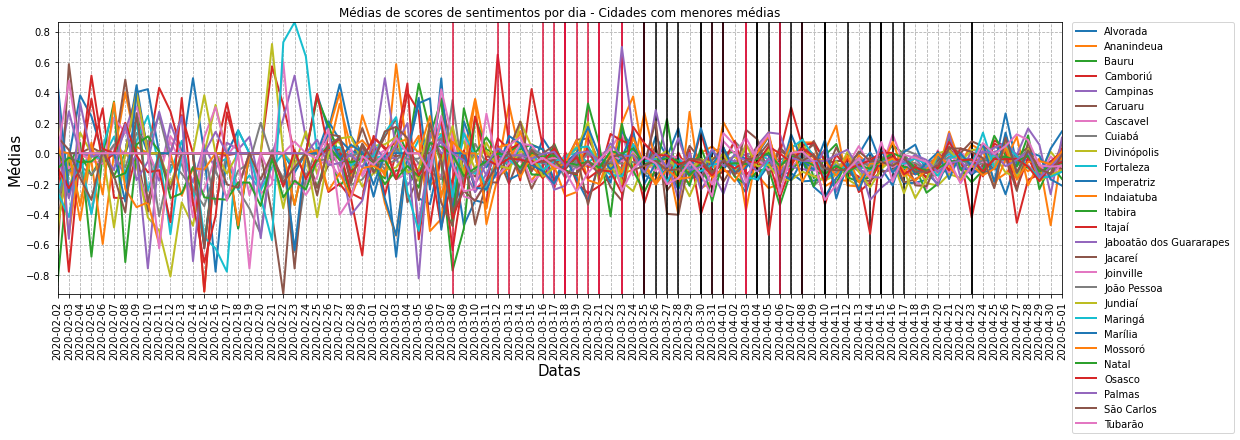

In [57]:
generate_cities_means_lines(df, df_cities_neg, 'M√©dias de scores de sentimentos por dia - Cidades com menores m√©dias')

Cidades com **maiores m√©dias** de sentimentos

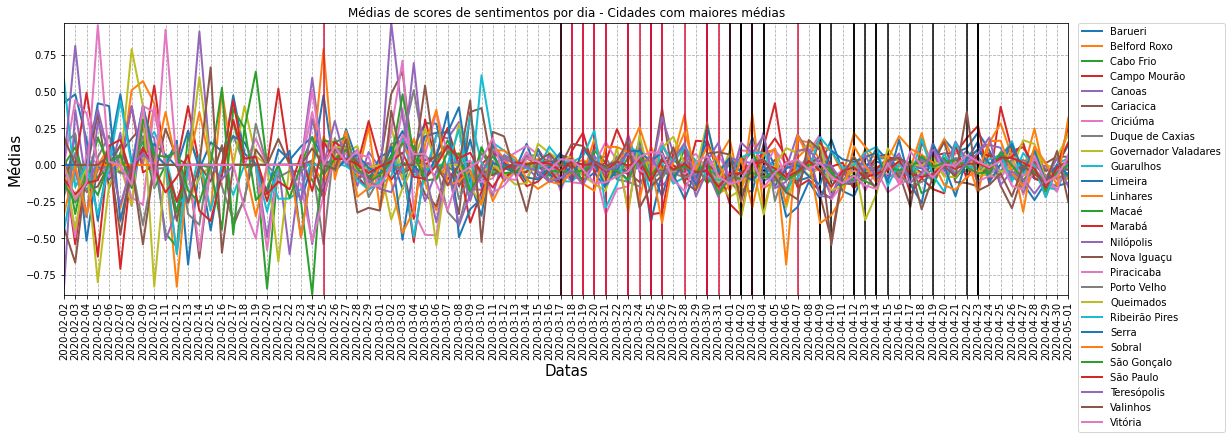

In [56]:
generate_cities_means_lines(df, df_cities_pos, 'M√©dias de scores de sentimentos por dia - Cidades com maiores m√©dias')

De acordo com os gr√°ficos acima, a **varia√ß√£o das m√©dias di√°rias dos sentimentos** para cada cidade **diminuiu √† medida que os primeiros casos e as primeiras mortes come√ßaram a ocorrer** em cada cidade. 

Com base nesta observa√ß√£o pode-se questionar:

- Pode-se sugerir que houve um alinhamento no discurso de usu√°rios em ambos os conjuntos de cidades?
- Pode-se sugerir que a houve uma acomoda√ß√£o na externaliza√ß√£o dos sentimentos dos usu√°rios em rea√ß√£o ao avan√ßo da pandemia?

***
### Resumo

Este *notebook* apresentou uma an√°lise com base nos resultados de sentimentos obtidos na base de dados selecionada na etapa anterior deste trabalho.

A partir de uma **base de dados com Casos de Covid-19 no Brasil**, foram extra√≠dos os intervalos para a defini√ß√£o dos **3 per√≠odos** analisados por este trabalho, para cada cidade, sendo eles: **antes do primeiro caso de Covid-19**, **ap√≥s o primeiro caso de Covid-19**, **ap√≥s a primeira morte por Covid-19**.

Com base em m√©tricas estat√≠sticas sobre os resultados dos *scores* de sentimentos foram criados **conjuntos** contendo as cidades com **menores e maiores m√©dias de *scores* de sentimentos**. 

A partir destes conjuntos foram gerados gr√°ficos com a finalidade de se observar **padr√µes comportamentais dos usu√°rios**, a partir dos **sentimentos resultantes dos 3 per√≠odos analisados**.

Por fim, este trabalho lista uma s√©rie de **observa√ß√µes extra√≠das destes resultados** e sugere **questionamentos relacionados √†s rea√ß√µes dos usu√°rios em rela√ß√£o em rela√ß√£o √† pandemia da Covid-19 no Brasil**.

***
### Fontes

(1) VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text

(2) Brasil.io - Boletins informativos e casos do coronav√≠rus por munic√≠pio por dia -https://brasil.io/dataset/covid19/caso_full/